In [5]:
!pip install tensorflow-datasets 

  Obtaining dependency information for tensorflow-datasets from https://files.pythonhosted.org/packages/fe/18/4865973f5469cfe33bbe1cfc2f1918335eb44f4cc3d316c1bce22c1af2bc/tensorflow_datasets-4.9.4-py3-none-any.whl.metadata
  Obtaining dependency information for dm-tree from https://files.pythonhosted.org/packages/e4/c1/522041457444b67125ac9527208bb3148f63d7dce0a86ffa589ec763a10e/dm_tree-0.1.8-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for etils[enp,epath,etree]>=0.9.0 from https://files.pythonhosted.org/packages/d0/3c/784b5f94bcad62a4167f2347fe1095b627433c22a54aecc4504237494b81/etils-1.8.0-py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for tensorflow-metadata from https://files.pythonhosted.org/packages/aa/47/91d1eea615b12473853edcbc0db02c94918e498bdf36049dde13bf24100d/tensorflow_metadata-1.15.0-py3-none-any.whl.metadata
  Obtaining dependency i

In [7]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
import keras
import tensorflow_datasets as tfds
from keras.layers import TextVectorization

In [8]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)


In [127]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [10]:
class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

In [18]:
train_df = pd.read_csv("C:/Users/ianre/OneDrive/Documents/Deep Learning/train.csv")
test_df = pd.read_csv("C:/Users/ianre/OneDrive/Documents/Deep Learning/test.csv")

In [20]:
train_df, val_df = train_test_split(train_df, test_size=0.05, random_state=42)

In [21]:
print(f"There are {train_df.shape[0]} news articles for training.")
print(f"There are {val_df.shape[0]} news articles for validation.")
print(f"There are {test_df.shape[0]} news articles for testing.")

There are 114000 news articles for training.
There are 6000 news articles for validation.
There are 7600 news articles for testing.


In [22]:
train_df.head(2).T

,56359,70571
Class Index,1,1
Title,China Offers Rewards for Reporting Porn (AP),Quake has thousands sleeping out
Description,AP - China's police ministry on Sunday handed ...,Thousands of people in northern Japan are spen...


In [23]:
test_df.head(2).T

,0,1
Class Index,3,4
Title,Fears for T N pension after talks,The Race is On: Second Private Team Sets Launc...
Description,Unions representing workers at Turner Newall...,"SPACE.com - TORONTO, Canada -- A second\team o..."


In [24]:
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [31]:
all_df.head(2).T

,0,1
Label,1,1
Title,China Offers Rewards for Reporting Porn (AP),Quake has thousands sleeping out
Description,AP - China's police ministry on Sunday handed ...,Thousands of people in northern Japan are spen...
Title_Description,China Offers Rewards for Reporting Porn (AP)_A...,Quake has thousands sleeping out_Thousands of ...


In [27]:
train_df.rename(columns={'Class Index': 'Label'}, inplace=True)
val_df.rename(columns={'Class Index': 'Label'}, inplace=True)
test_df.rename(columns={'Class Index': 'Label'}, inplace=True)
all_df.rename(columns={'Class Index': 'Label'}, inplace=True)

In [29]:
categories = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
all_df.Label.value_counts(sort=False).rename(index=categories)

World       31900
Sports      31900
Business    31900
Sci/Tech    31900
Name: Label, dtype: int64

In [30]:
train_df['Title_Description'] = train_df['Title'] + '_' + train_df['Description']
val_df['Title_Description'] = val_df['Title'] + '_' + val_df['Description']
test_df['Title_Description'] = test_df['Title'] + '_' + test_df['Description']
all_df['Title_Description'] = all_df['Title'] + '_' + all_df['Description']

In [33]:
train_df.to_csv('train_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)
all_df.to_csv('all_df.csv', index=False)

In [34]:
batch_size = 32
train_ds =\
tf.data.experimental.make_csv_dataset("C:/Users/ianre/OneDrive/Documents/Deep Learning/train_df.csv",select_columns=['Title_Description','Label'],
                                      label_name="Label",num_epochs=1, batch_size=batch_size)
val_ds =\
tf.data.experimental.make_csv_dataset("C:/Users/ianre/OneDrive/Documents/Deep Learning/val_df.csv",select_columns=['Title_Description','Label'],
                                      label_name="Label",num_epochs=1,batch_size=batch_size)
test_ds =\
tf.data.experimental.make_csv_dataset("C:/Users/ianre/OneDrive/Documents/Deep Learning/test_df.csv",select_columns=['Title_Description','Label'],
                                      label_name="Label",num_epochs=1,batch_size=batch_size)

In [35]:
for inputs, targets in train_ds:
    print(f"The first batch has {inputs['Title_Description'].shape[0]} articles with {targets.shape[0]} labels.")
    print(f"The articles have type {inputs['Title_Description'].dtype}, the labels type: {targets.dtype}\n")

    # just print the first news article in the batch
    print(f"The first news article:\n{inputs['Title_Description'][0]}\n")

    print(f"It is a {categories[targets[0].numpy()]} article.")
    break

The first batch has 32 articles with 32 labels.
The articles have type <dtype: 'string'>, the labels type: <dtype: 'int32'>

The first news article:
b'Chico #39;s 3Q Profit Surges; Shares Climb_Women #39;s clothing retailer Chico #39;s FAS Inc. on Tuesday posted a 39 percent jump in third-quarter profit, helped by sharply higher sales and improved margins.'

It is a Business article.


In [37]:
all_ds =\
tf.data.experimental.make_csv_dataset("C:/Users/ianre/OneDrive/Documents/Deep Learning/all_df.csv",select_columns=['Title_Description','Label'],
                                      label_name="Label",num_epochs=1, batch_size=1)

In [38]:
text_vectorization = TextVectorization(
    output_mode="int",
)
text_only_all_ds = all_ds.map(lambda x, y: x['Title_Description'])

In [39]:
for text in text_only_all_ds:
    print(f"Get first batch of {text.shape[0]} news articles.\n")
    print(f"Here is the first news article:\n\n{text[0]}.")
    break

Get first batch of 1 news articles.

Here is the first news article:

b'Garnett does it all for Timberwolves_Kevin Garnett had 25 points, 21 rebounds and eight assists to pace the Minnesota Timberwolves to a 108-97 victory Tuesday against the visiting Miami Heat.'.


In [40]:
%%time
text_vectorization.adapt(text_only_all_ds)


CPU times: total: 36.2 s
Wall time: 5min 22s


In [41]:
vocab = text_vectorization.get_vocabulary()
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 178424 vocabulary words in the corpus.


In [42]:
vocab[:12]

['', '[UNK]', 'the', 'to', 'a', 'of', 'in', 'and', 'on', 'for', '39s', 'that']

In [43]:
%%time
doc_sizes = []
corpus = []
for example, _ in all_ds:
  enc_example = text_vectorization(example['Title_Description'])
  doc_sizes.append(enc_example.shape[1])
  corpus+=list(enc_example.numpy()[0])

CPU times: total: 13min 20s
Wall time: 14min 34s


In [44]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 4655592 words in the corpus of 127600 news articles.
Each news article has between 3 and 176 tokens in it.


In [45]:
corpus[:5]

[360, 10, 809, 85811, 360]

Experimet A

Plot Distribution of Percent of Non-Vocabulary Words in News Articles

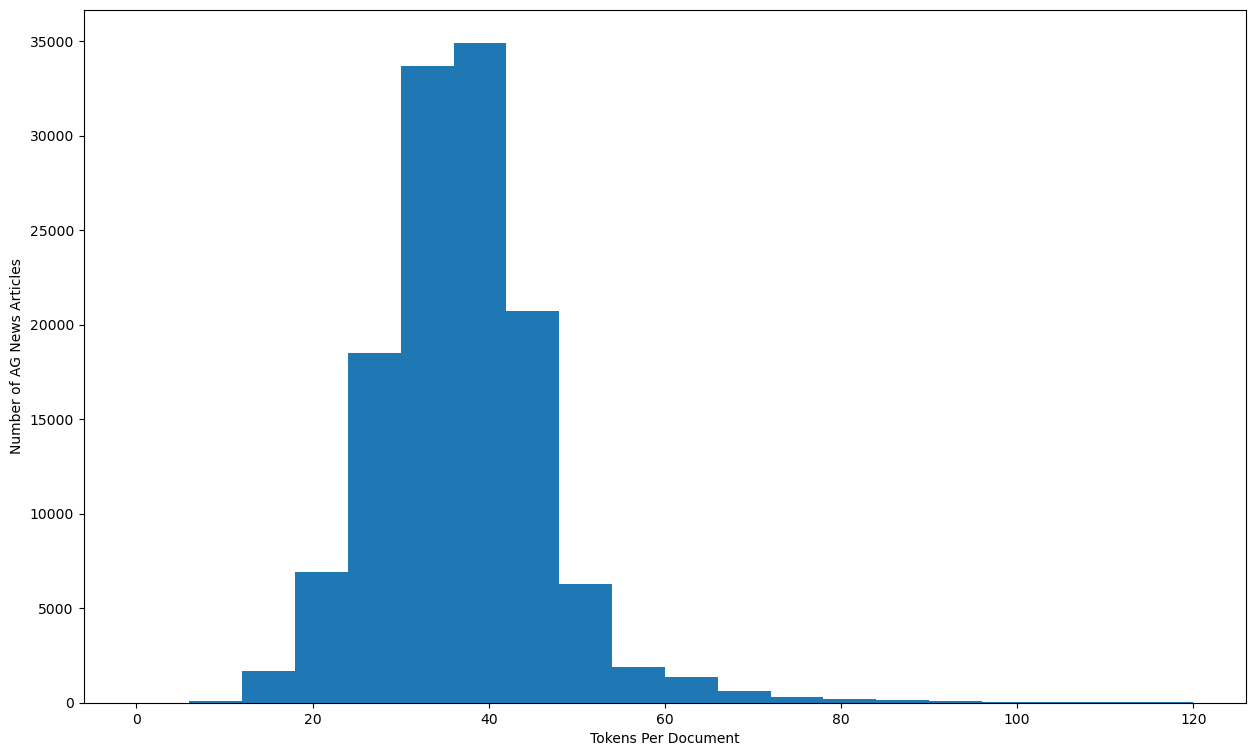

In [46]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

Top 1000

In [47]:
%%time
from tensorflow.keras.layers import TextVectorization
encoder_1000 = TextVectorization(
    output_mode="int",
    max_tokens=1000
)
encoder_1000.adapt(text_only_all_ds)
vocab_1000 = np.array(encoder_1000.get_vocabulary());

CPU times: total: 26.7 s
Wall time: 3min 56s


In [48]:
vocab_1000[:20]

array(['', '[UNK]', 'the', 'to', 'a', 'of', 'in', 'and', 'on', 'for',
       '39s', 'that', 'with', 'as', 'at', 'its', 'is', 'by', 'said',
       'new'], dtype='<U14')

In [49]:
#Encoder Example
example = "the dog ran after a red ball as it rolled by the hat on the ground."
enc_example = encoder_1000(example).numpy()
enc_example

array([  2,   1,   1,  27,   4, 175,   1,  13,  21,   1,  17,   2,   1,
         8,   2,   1], dtype=int64)

In [50]:
num_ones = tf.math.count_nonzero(enc_example==1).numpy()
num_ones


6

In [53]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = encoder_1000(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: total: 17min 9s
Wall time: 18min 54s


Plot Distribution of Percent of 1000 Word Vocabulary in News Articles

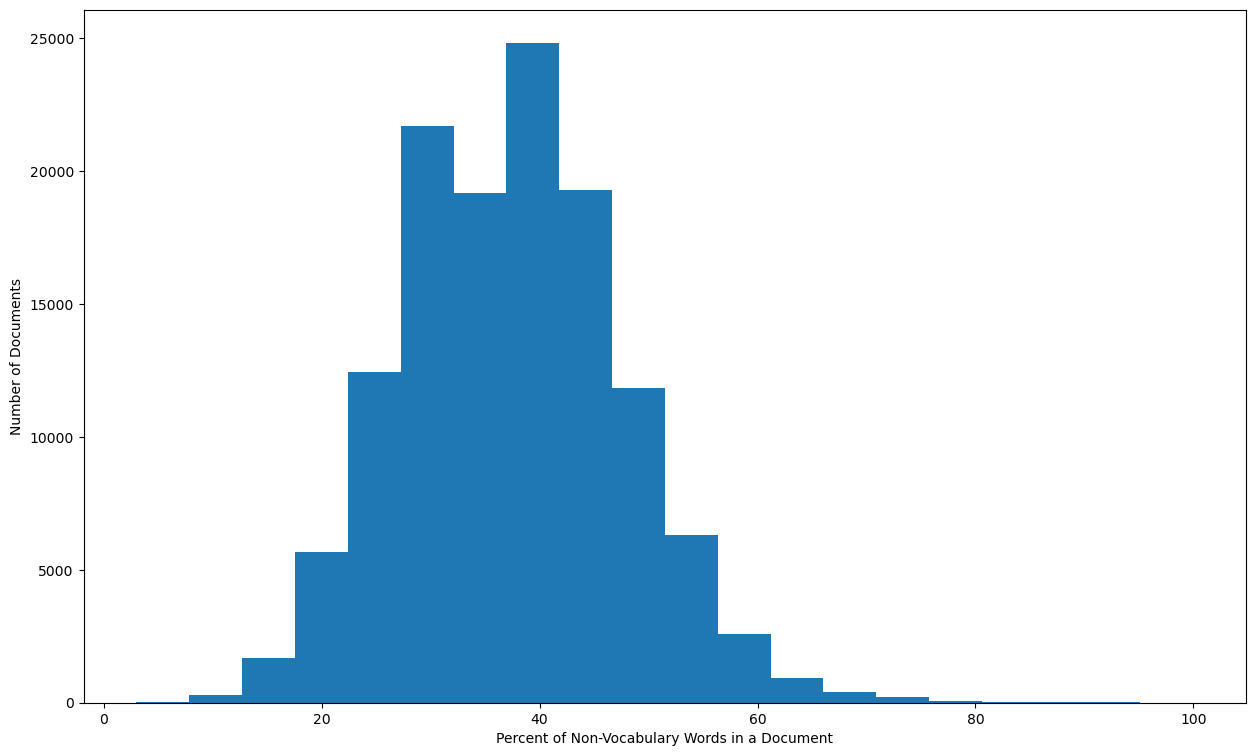

In [54]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [55]:
print(f"Each news article has between {min(doc1000_sizes)}\
and {max(doc1000_sizes)} tokens in it.")

Each news article has between 3and 176 tokens in it.


Top 10,000

In [56]:
%%time
from tensorflow.keras.layers import TextVectorization
encoder_10000 = TextVectorization(
    output_mode="int",
    max_tokens=10000
)
encoder_10000.adapt(text_only_all_ds)
vocab_10000 = np.array(encoder_10000.get_vocabulary());

CPU times: total: 30.1 s
Wall time: 3min 56s


In [57]:
#Encoder Example
example = "the dog ran after a red ball as it rolled by the hat on the ground."
enc_example = encoder_10000(example).numpy()
enc_example

array([   2, 5086, 1528,   27,    4,  175, 1467,   13,   21, 3033,   17,
          2, 1762,    8,    2, 1043], dtype=int64)

In [58]:
%%time
doc10000_sizes = []
corpus10000 = []
count10000=0
useless = 0
# stop = 0
percents = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = encoder_10000(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  doc10000_sizes.append(len(enc_example))
  corpus10000+=list(enc_example.numpy())

  count10000 += tf.math.count_nonzero(enc_example>1)

CPU times: total: 17min 12s
Wall time: 30min 38s


Plot Distribution of Percent of 10,000 Word Vocabulary in News Articles

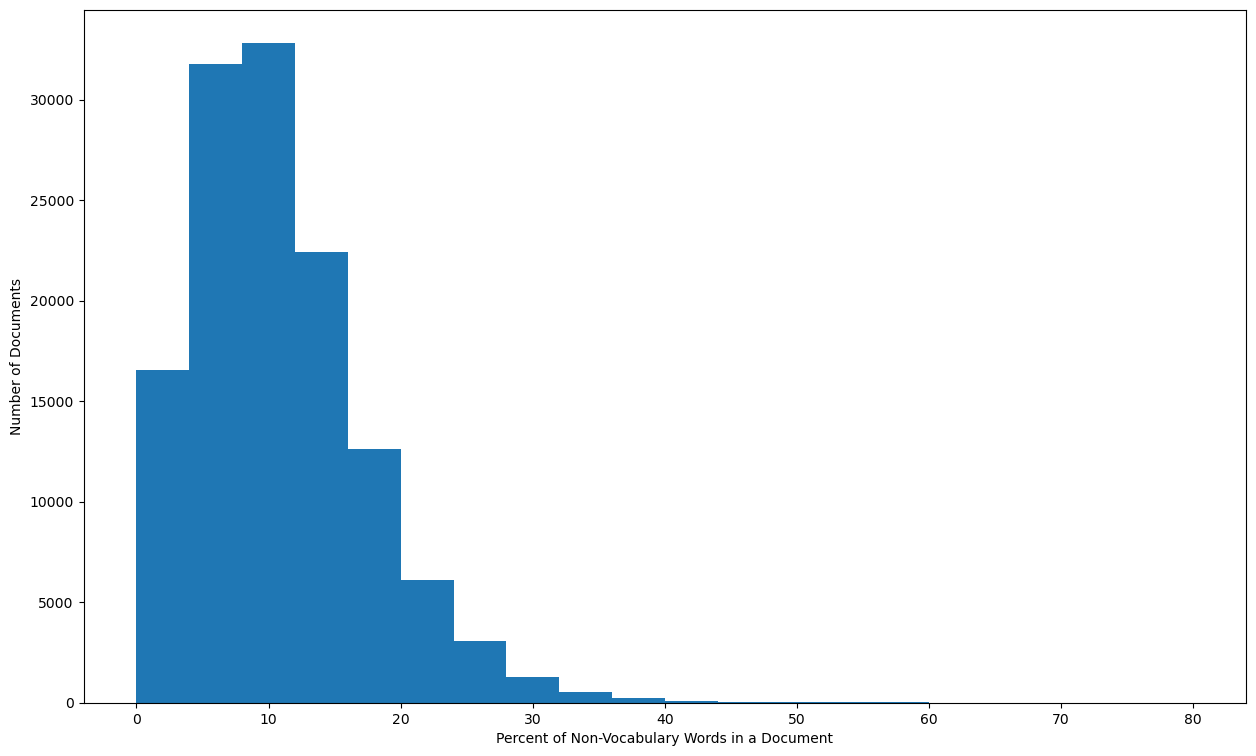

In [59]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [60]:
print(f"Each news article has between {min(doc10000_sizes)}\
 and {max(doc10000_sizes)} tokens in it.")

Each news article has between 3 and 176 tokens in it.


Top 5,000

In [61]:
%%time
from tensorflow.keras.layers import TextVectorization
encoder_5000 = TextVectorization(
    output_mode="int",
    max_tokens=5000
)
encoder_5000.adapt(text_only_all_ds)
vocab_5000 = np.array(encoder_5000.get_vocabulary());

CPU times: total: 48.5 s
Wall time: 4min 3s


In [62]:
#Encoder Example
example = "the dog ran after a red ball as it rolled by the hat on the ground."
enc_example = encoder_5000(example).numpy()
enc_example

array([   2,    1, 1528,   27,    4,  175, 1467,   13,   21, 3033,   17,
          2, 1762,    8,    2, 1043], dtype=int64)

In [63]:
%%time
doc5000_sizes = []
corpus5000 = []
count5000=0
useless = 0
# stop = 0
percents = []
for example, _ in all_ds.as_numpy_iterator():
#   stop+=1
#   if stop > 2: break
  enc_example = encoder_5000(example['Title_Description'])[0]
#   print(enc_example)

  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
#   print(num_ones)
  percent_ones = round(num_ones*100/len(enc_example))
#   print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1
#   print(useless)

  doc5000_sizes.append(len(enc_example))
  corpus5000+=list(enc_example.numpy())

  count5000 += tf.math.count_nonzero(enc_example>1)

CPU times: total: 13min 49s
Wall time: 27min 22s


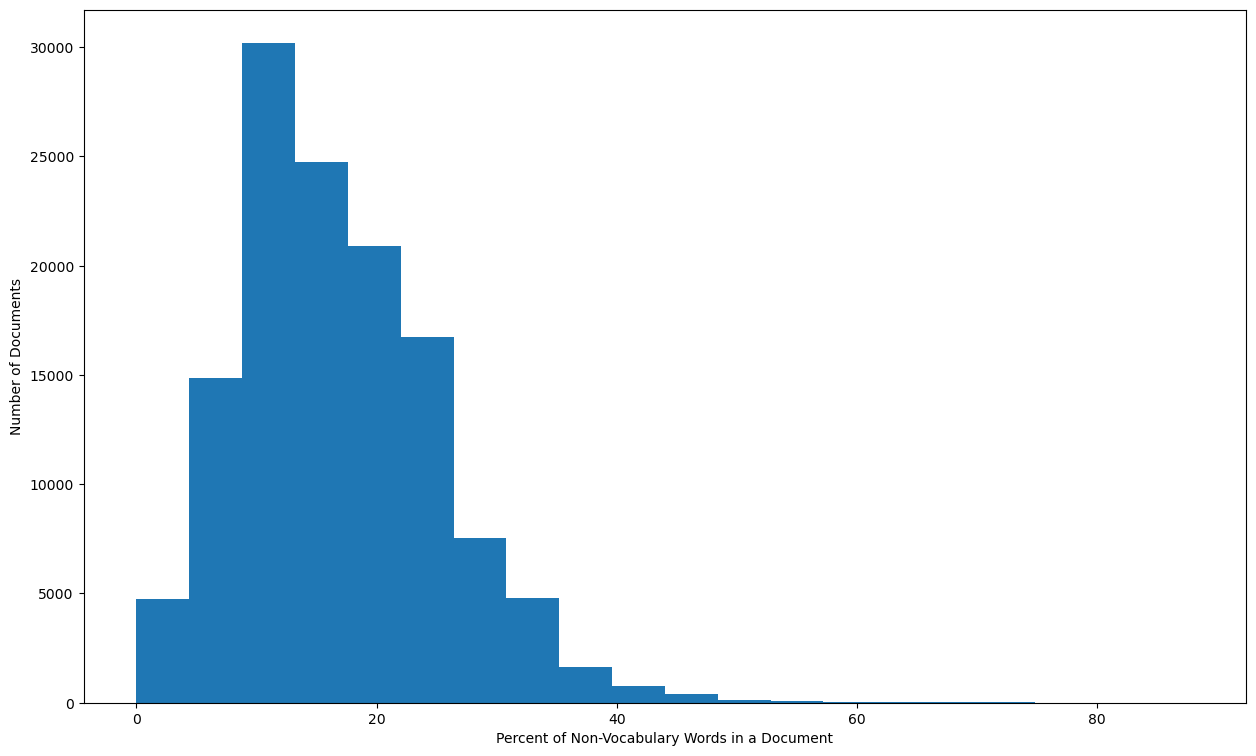

In [64]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [65]:
print(f"Each news article has between {min(doc5000_sizes)}\
 and {max(doc5000_sizes)} tokens in it.")

Each news article has between 3 and 176 tokens in it.


Experiment B

In [66]:
from packaging import version
import numpy as np
import re
import string
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import keras
from keras import layers

import nltk
from nltk.corpus import stopwords

In [67]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [68]:
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.datasets.ag_news_subset.ag_news_subset_dataset_builder
WARNING[module_wrapper.py]: From C:\Users\ianre\anaconda3\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

INFO[utils.py]: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO[utils.py]: NumExpr defaulting to 8 threads.
INFO[build.py]: download_and_prepare for dataset ag_news_subset/1.0.0...
INFO[dataset_builder.py]: Generating dataset ag_news_subset (C:\Users\ianre\tensorflow_datasets\ag_news_subset\1.0.0)
INFO[download_manager.py]: Downloading https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbUDNpeUdjb0wxRms into C:\Users\ianre\tensorflow_datasets\downloads\ucexport_download_id_0Bz8a_Dbh9QhbUDNpeUdjb0wxj4g1umFAV8OV-uDwxSJR0LdxO_k1jxMuFWwAfNX9jos.tmp.4d9a3db5de4441d8b

W0511 18:03:30.996423 16496 download_and_prepare.py:46] ***`tfds build` should be used instead of `download_and_prepare`.***
2024-05-11 18:03:31.392383: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]


Extraction completed...: 0 file [00:00, ? file/s]
                                       


                                  



                                                 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]


Extraction completed...: 0 file [00:00, ? file/s]
Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]


Extraction completed...: 0 file [00:00, ? file/s]
Dl Completed...:   0%|          | 0/1 [00:16<?, 

In [69]:
nltk.download('stopwords')
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ianre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
max_length = 150
max_tokens = 1000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Model 1: Simple Bidirectional RNN using One Hot Encoder Vector Space

In [96]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.SimpleRNN(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model1 = tf.keras.Model(inputs, outputs)
model1.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model1.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 tf.one_hot_4 (TFOpLambda)   (None, None, 1000)        0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 64)                66112     
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 4)                 260       
                                                                 
Total params: 66372 (259.27 KB)
Trainable params: 66372 (259.27 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [97]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("one_hot_bidir_simplernn.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history1=model1.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model1 = keras.models.load_model("one_hot_bidir_simplernn.keras")
end_time = time.time()
second_elapsed_1 = round(end_time - start_time)

print(f'Finished model training in {second_elapsed_1}s')

Epoch 1/10
3563/3563 [==============================] - 208s 58ms/step - loss: 0.6329 - accuracy: 0.7684 - val_loss: 0.4652 - val_accuracy: 0.8428
Epoch 2/10
3563/3563 [==============================] - 190s 53ms/step - loss: 0.4981 - accuracy: 0.8312 - val_loss: 0.4552 - val_accuracy: 0.8440
Epoch 3/10
3563/3563 [==============================] - 173s 48ms/step - loss: 0.4815 - accuracy: 0.8373 - val_loss: 0.4673 - val_accuracy: 0.8420
Epoch 4/10
3563/3563 [==============================] - 169s 47ms/step - loss: 0.4730 - accuracy: 0.8403 - val_loss: 0.4583 - val_accuracy: 0.8447
Epoch 5/10
3563/3563 [==============================] - 168s 47ms/step - loss: 0.4603 - accuracy: 0.8454 - val_loss: 0.4430 - val_accuracy: 0.8500
Epoch 6/10
3563/3563 [==============================] - 164s 46ms/step - loss: 0.4475 - accuracy: 0.8502 - val_loss: 0.4280 - val_accuracy: 0.8553
Epoch 7/10
3563/3563 [==============================] - 167s 47ms/step - loss: 0.4410 - accuracy: 0.8531 - val_loss: 0

In [98]:
test_loss1, test_acc1 = model1.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc1}, Test loss: {test_loss1}")

238/238 [==============================] - 8s 30ms/step - loss: 0.4326 - accuracy: 0.8518
Test accuracy: 0.8518421053886414, Test loss: 0.4326461851596832


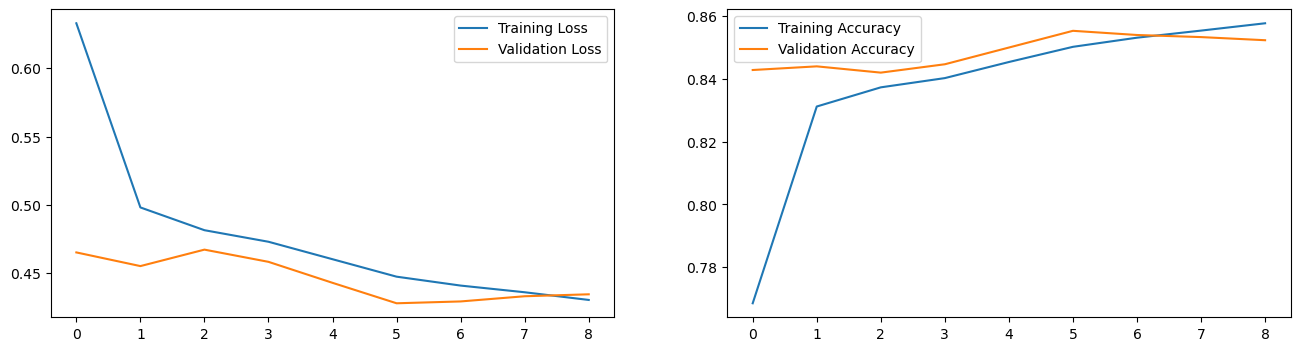

In [128]:
plot_history(history1)

Model 2: Simple Bidirectional RNN with Word Embeddings

In [102]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.SimpleRNN(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model2 = tf.keras.Model(inputs, outputs)
model2.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model2.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_simpleRNN.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history2=model2.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model2 = keras.models.load_model("embeddings_bidir_simpleRNN.keras")
end_time = time.time()
second_elapsed_2 = round(end_time - start_time)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9 (Embedding)     (None, None, 256)         256000    
                                                                 
 bidirectional_11 (Bidirect  (None, 64)                18496     
 ional)                                                          
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 4)                 260       
                                                                 
Total params: 274756 (1.05 MB)
Trainable params: 274756 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [103]:
test_loss2, test_acc2 = model2.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc2}, Test loss: {test_loss2}")

238/238 [==============================] - 5s 15ms/step - loss: 0.4229 - accuracy: 0.8522
Test accuracy: 0.8522368669509888, Test loss: 0.42285674810409546


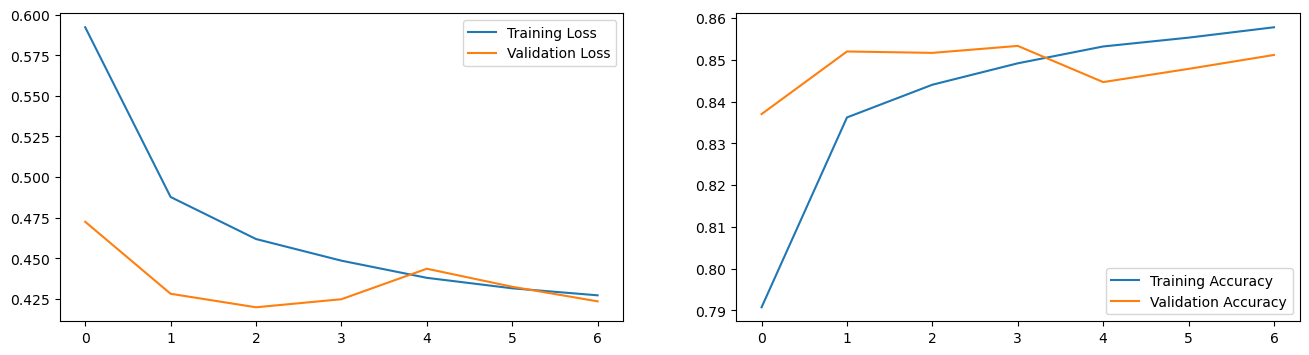

In [129]:
plot_history(history2)

Model 3: Simple Uni-Directional RNN with word Embedding

In [104]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.SimpleRNN(32)(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model3 = tf.keras.Model(inputs, outputs)
model3.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model3.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_unidir_simpleRNN.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history3=model3.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model3 = keras.models.load_model("embeddings_unidir_simpleRNN.keras")
end_time = time.time()
second_elapsed_3 = round(end_time - start_time)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_10 (Embedding)    (None, None, 256)         256000    
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 32)                9248      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 4)                 132       
                                                                 
Total params: 265380 (1.01 MB)
Trainable params: 265380 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
3563/3563 [

In [105]:
test_loss3, test_acc3 = model3.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc3}, Test loss: {test_loss3}")

238/238 [==============================] - 4s 15ms/step - loss: 1.3866 - accuracy: 0.2500
Test accuracy: 0.25, Test loss: 1.3866169452667236


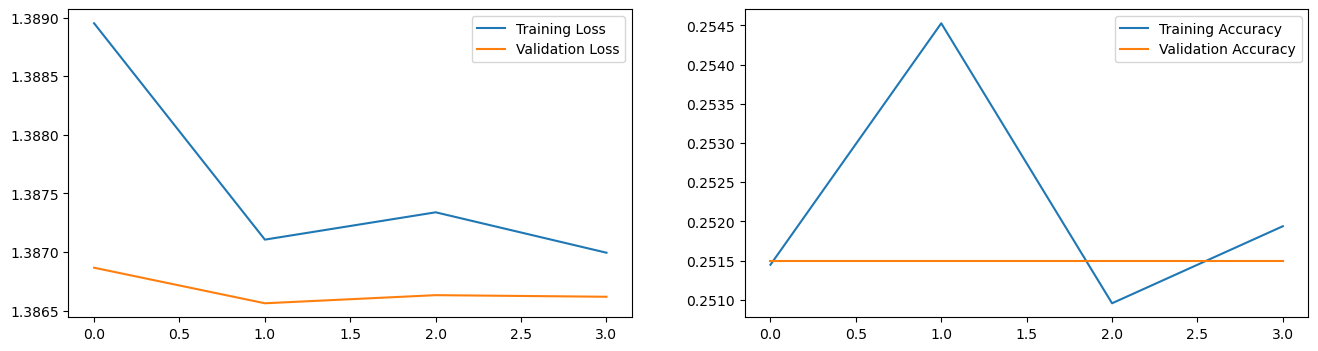

In [130]:
plot_history(history3)

Model 4: RNN with GRU and word Embedding

In [106]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.GRU(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model4 = tf.keras.Model(inputs, outputs)
model4.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model4.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_GRU.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history4=model4.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model4 = keras.models.load_model("embeddings_bidir_GRU.keras")
end_time = time.time()
second_elapsed_4 = round(end_time - start_time)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_11 (Embedding)    (None, None, 256)         256000    
                                                                 
 bidirectional_12 (Bidirect  (None, 64)                55680     
 ional)                                                          
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 4)                 260       
                                                                 
Total params: 311940 (1.19 MB)
Trainable params: 311940 (1.19 MB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [107]:
test_loss4, test_acc4 = model4.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc4}, Test loss: {test_loss4}")

238/238 [==============================] - 8s 26ms/step - loss: 0.3934 - accuracy: 0.8632
Test accuracy: 0.8631578683853149, Test loss: 0.3933694660663605


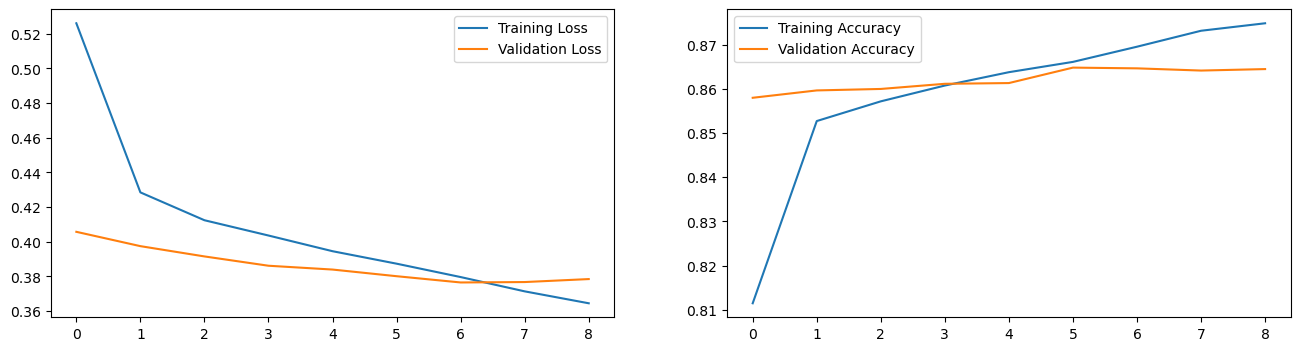

In [131]:
plot_history(history4)

Model 5: Simple RNN with word embedding and adjusted Dropout

In [109]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.SimpleRNN(32))(embedded)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model5 = tf.keras.Model(inputs, outputs)
model5.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model5.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_0.2dropout.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history5=model5.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model5 = keras.models.load_model("embeddings_bidir_0.2dropout.keras")
end_time = time.time()
second_elapsed_5 = round(end_time - start_time)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_13 (Embedding)    (None, None, 256)         256000    
                                                                 
 bidirectional_14 (Bidirect  (None, 64)                18496     
 ional)                                                          
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 4)                 260       
                                                                 
Total params: 274756 (1.05 MB)
Trainable params: 274756 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [110]:
test_loss5, test_acc5 = model5.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc5}, Test loss: {test_loss5}")

238/238 [==============================] - 5s 16ms/step - loss: 0.4241 - accuracy: 0.8528
Test accuracy: 0.8527631759643555, Test loss: 0.4241216778755188


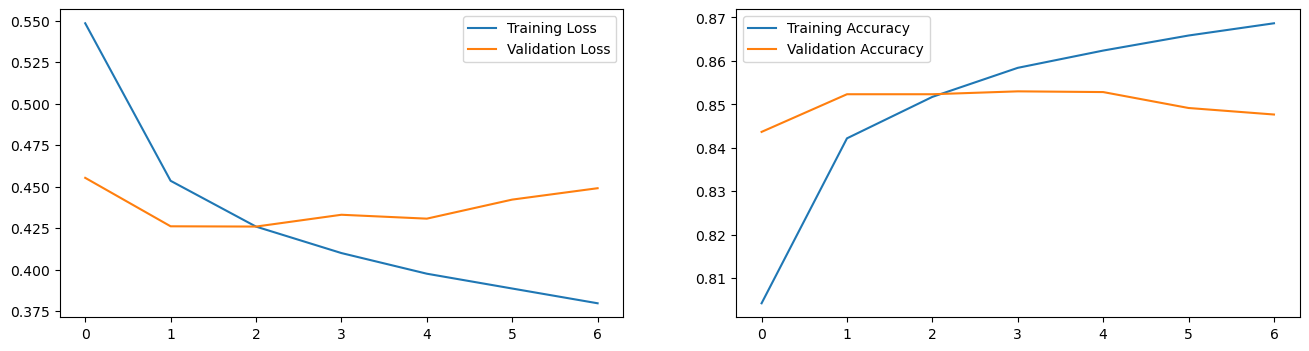

In [132]:
plot_history(history5)

Model 6: Simple RNN with additional layers

In [161]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.SimpleRNN(128))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model6 = tf.keras.Model(inputs, outputs)
model6.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model6.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_128nodes.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history6=model6.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model6 = keras.models.load_model("embeddings_bidir_128nodes.keras")
end_time = time.time()
second_elapsed_6 = round(end_time - start_time)

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_29 (Embedding)    (None, None, 256)         256000    
                                                                 
 bidirectional_23 (Bidirect  (None, 256)               98560     
 ional)                                                          
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 355588 (1.36 MB)
Trainable params: 355588 (1.36 MB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [162]:
test_loss6, test_acc6 = model6.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc6}, Test loss: {test_loss6}")

238/238 [==============================] - 6s 22ms/step - loss: 0.4249 - accuracy: 0.8562
Test accuracy: 0.856184184551239, Test loss: 0.4249221682548523


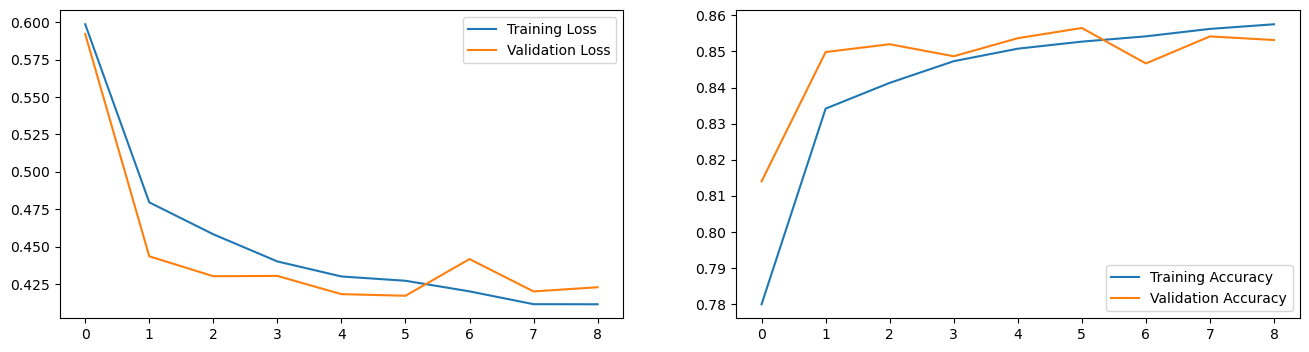

In [163]:
plot_history(history6)

Model 7: Simple RNN with Regularization

In [116]:
from tensorflow.keras import regularizers
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.SimpleRNN(32, kernel_regularizer=regularizers.l2(0.01)))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model7 = tf.keras.Model(inputs, outputs)
model7.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model7.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_regularization.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history7=model7.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model7 = keras.models.load_model("embeddings_bidir_regularization.keras")
end_time = time.time()
second_elapsed_7 = round(end_time - start_time)

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_17 (Embedding)    (None, None, 256)         256000    
                                                                 
 bidirectional_16 (Bidirect  (None, 64)                18496     
 ional)                                                          
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 4)                 260       
                                                                 
Total params: 274756 (1.05 MB)
Trainable params: 274756 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [117]:
test_loss7, test_acc7 = model7.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc7}, Test loss: {test_loss7}")

238/238 [==============================] - 6s 20ms/step - loss: 0.4566 - accuracy: 0.8426
Test accuracy: 0.8426315784454346, Test loss: 0.4565746486186981


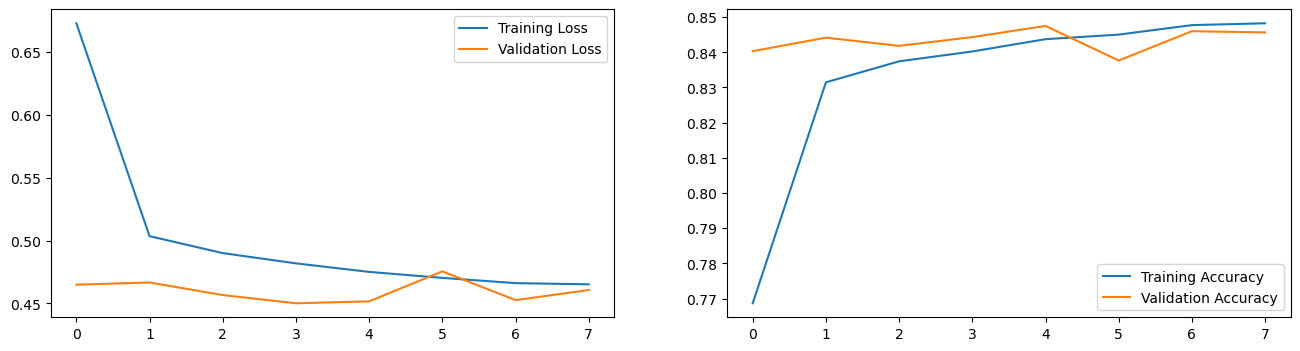

In [134]:
plot_history(history7)

Experiment C

Model 8: LSTM with word embedding

In [118]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model8 = tf.keras.Model(inputs, outputs)
model8.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model8.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_LSTM.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history8=model8.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model8 = keras.models.load_model("embeddings_bidir_LSTM.keras")
end_time = time.time()
second_elapsed_8 = round(end_time - start_time)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_18 (Embedding)    (None, None, 256)         256000    
                                                                 
 bidirectional_17 (Bidirect  (None, 64)                73984     
 ional)                                                          
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 4)                 260       
                                                                 
Total params: 330244 (1.26 MB)
Trainable params: 330244 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [119]:
test_loss8, test_acc8 = model8.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc8}, Test loss: {test_loss8}")

238/238 [==============================] - 9s 28ms/step - loss: 0.3936 - accuracy: 0.8621
Test accuracy: 0.8621052503585815, Test loss: 0.3935554623603821


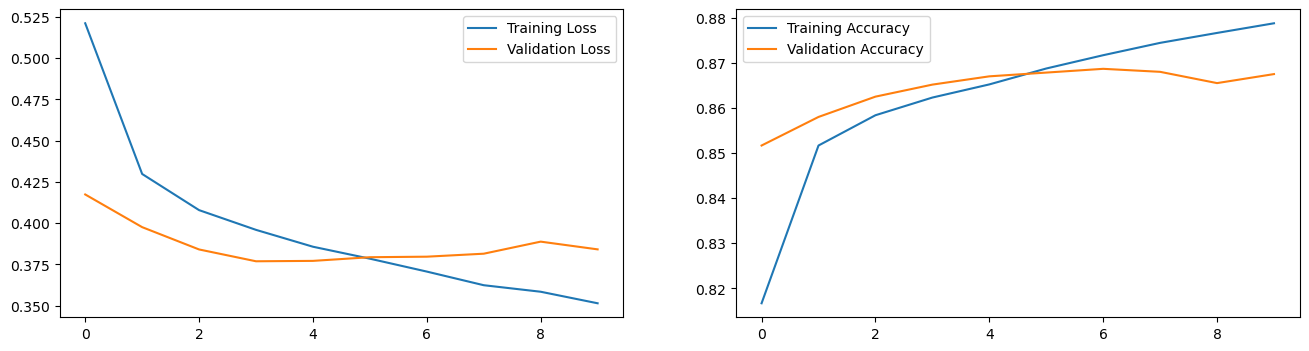

In [135]:
plot_history(history8)

Model 9: LSTM with New Nodes

In [120]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(128))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model9 = tf.keras.Model(inputs, outputs)
model9.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model9.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_LSTM.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history9=model9.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model9 = keras.models.load_model("embeddings_bidir_LSTM.keras")
end_time = time.time()
second_elapsed_9 = round(end_time - start_time)

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_19 (Embedding)    (None, None, 256)         256000    
                                                                 
 bidirectional_18 (Bidirect  (None, 256)               394240    
 ional)                                                          
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 651268 (2.48 MB)
Trainable params: 651268 (2.48 MB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [121]:
test_loss9, test_acc9 = model9.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc9}, Test loss: {test_loss9}")

238/238 [==============================] - 23s 86ms/step - loss: 0.3847 - accuracy: 0.8636
Test accuracy: 0.8635526299476624, Test loss: 0.3846913278102875


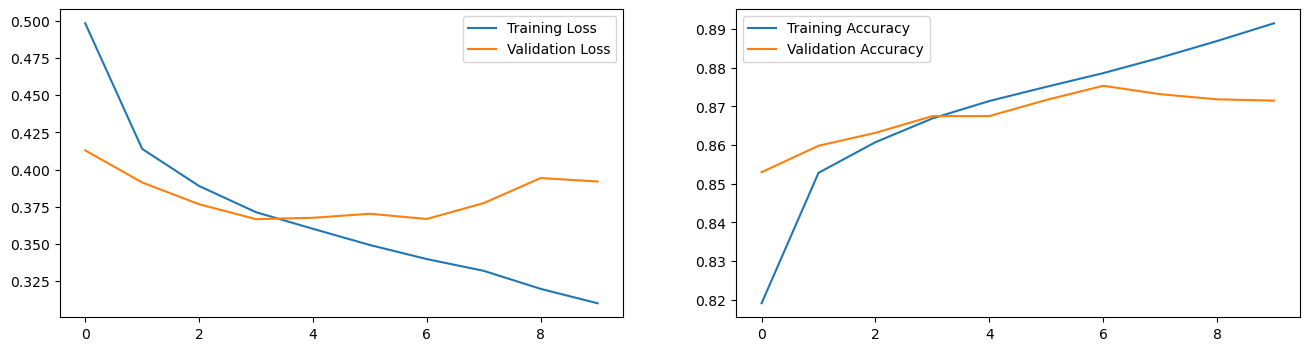

In [136]:
plot_history(history9)

Model 10: Unidirectional LSTM

In [122]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.LSTM(32)(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model10 = tf.keras.Model(inputs, outputs)
model10.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model10.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_unidir_LSTM.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history10=model10.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model10 = keras.models.load_model("embeddings_unidir_LSTM.keras")
end_time = time.time()
second_elapsed_10 = round(end_time - start_time)

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_20 (Embedding)    (None, None, 256)         256000    
                                                                 
 lstm_3 (LSTM)               (None, 32)                36992     
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 4)                 132       
                                                                 
Total params: 293124 (1.12 MB)
Trainable params: 293124 (1.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
3563/3563 [

In [124]:
test_loss10, test_acc10 = model10.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc10}, Test loss: {test_loss10}")

238/238 [==============================] - 8s 27ms/step - loss: 1.3866 - accuracy: 0.2500
Test accuracy: 0.25, Test loss: 1.3865532875061035


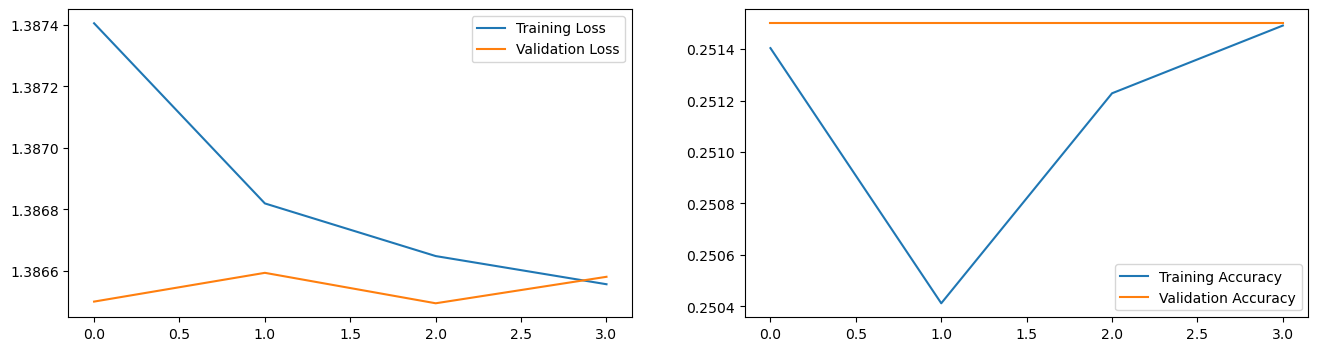

In [137]:
plot_history(history10)

Model 11: LSTM with adjusted dropout

In [125]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model11 = tf.keras.Model(inputs, outputs)
model11.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model11.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_LSTM_0.2dropout.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history11=model11.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model11 = keras.models.load_model("embeddings_bidir_LSTM_0.2dropout.keras")
end_time = time.time()
second_elapsed_11 = round(end_time - start_time)

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_21 (Embedding)    (None, None, 256)         256000    
                                                                 
 bidirectional_19 (Bidirect  (None, 64)                73984     
 ional)                                                          
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 4)                 260       
                                                                 
Total params: 330244 (1.26 MB)
Trainable params: 330244 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [138]:
test_loss11, test_acc11 = model11.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc11}, Test loss: {test_loss11}")

238/238 [==============================] - 9s 25ms/step - loss: 0.3863 - accuracy: 0.8683
Test accuracy: 0.8682894706726074, Test loss: 0.3862766623497009


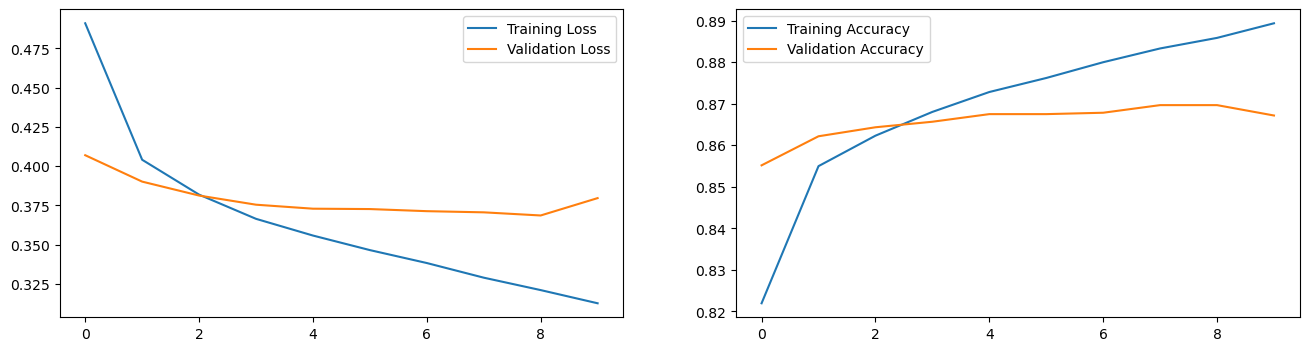

In [139]:
plot_history(history11)

Model 12: LSTM with Regularization and 0.01 Learning Rate

In [140]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32, kernel_regularizer=regularizers.l2(0.01)))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model12 = tf.keras.Model(inputs, outputs)
model12.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model12.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_LSTM_regularization.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history12=model12.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model12 = keras.models.load_model("embeddings_bidir_LSTM_regularization.keras")
end_time = time.time()
second_elapsed_12 = round(end_time - start_time)

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_22 (Embedding)    (None, None, 256)         256000    
                                                                 
 bidirectional_20 (Bidirect  (None, 64)                73984     
 ional)                                                          
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 4)                 260       
                                                                 
Total params: 330244 (1.26 MB)
Trainable params: 330244 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [141]:
test_loss12, test_acc12 = model12.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc12}, Test loss: {test_loss12}")

238/238 [==============================] - 12s 36ms/step - loss: 0.4464 - accuracy: 0.8483
Test accuracy: 0.8482894897460938, Test loss: 0.4463616609573364


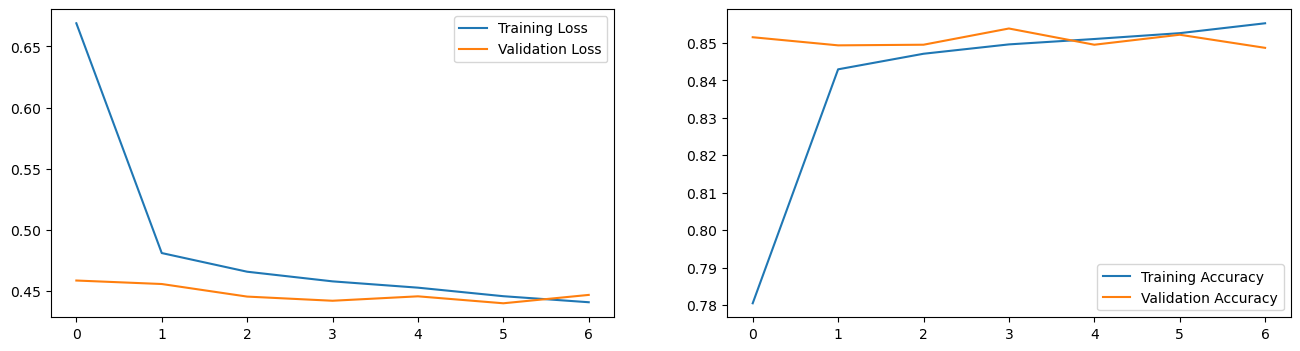

In [142]:
plot_history(history12)

Model 13: LSTM with Regularization and 0.1 Learning Rate

In [143]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32, kernel_regularizer=regularizers.l2(0.1)))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model13 = tf.keras.Model(inputs, outputs)
model13.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model13.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_LSTM_regularization2.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history13=model13.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model13 = keras.models.load_model("embeddings_bidir_LSTM_regularization2.keras")
end_time = time.time()
second_elapsed_13 = round(end_time - start_time)

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_23 (Embedding)    (None, None, 256)         256000    
                                                                 
 bidirectional_21 (Bidirect  (None, 64)                73984     
 ional)                                                          
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 4)                 260       
                                                                 
Total params: 330244 (1.26 MB)
Trainable params: 330244 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [144]:
test_loss13, test_acc13 = model13.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc13}, Test loss: {test_loss13}")

238/238 [==============================] - 9s 26ms/step - loss: 0.4703 - accuracy: 0.8467
Test accuracy: 0.8467105031013489, Test loss: 0.47025933861732483


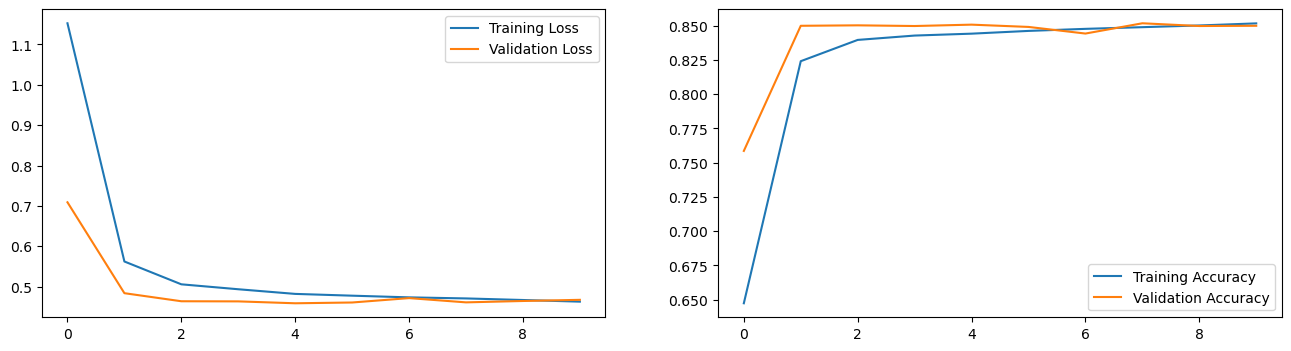

In [145]:
plot_history(history13)

Model 14: LSTM with New Word Embedding

In [155]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=10000, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model14 = tf.keras.Model(inputs, outputs)
model14.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model14.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_LSTM_new_embedding.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history14=model14.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model14 = keras.models.load_model("embeddings_bidir_LSTM_new_embedding.keras")
end_time = time.time()
second_elapsed_14 = round(end_time - start_time)

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_28 (Embedding)    (None, None, 256)         2560000   
                                                                 
 bidirectional_22 (Bidirect  (None, 64)                73984     
 ional)                                                          
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 4)                 260       
                                                                 
Total params: 2634244 (10.05 MB)
Trainable params: 2634244 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [156]:
test_loss14, test_acc14 = model14.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc14}, Test loss: {test_loss14}")

238/238 [==============================] - 8s 25ms/step - loss: 0.3877 - accuracy: 0.8642
Test accuracy: 0.8642105460166931, Test loss: 0.3877115249633789


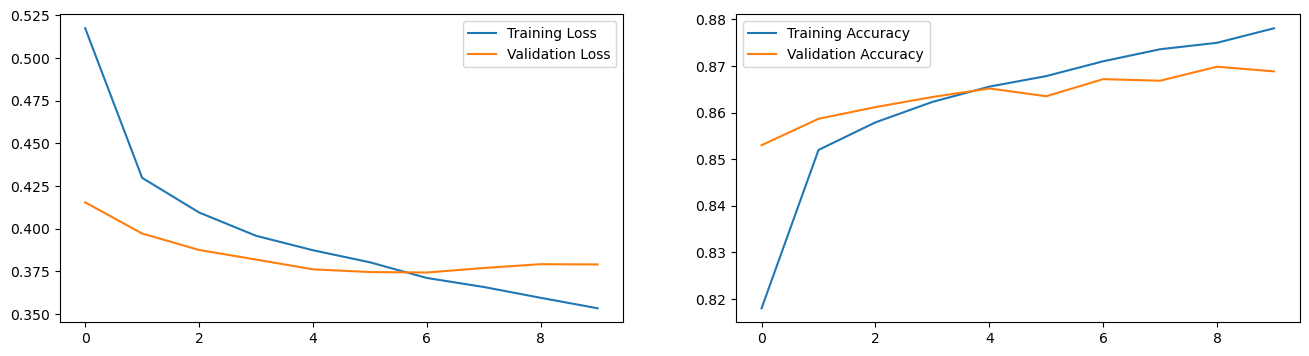

In [157]:
plot_history(history14)

In [167]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=1000, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.2)(x)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)
modelx = tf.keras.Model(inputs, outputs)
modelx.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
modelx.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_LSTM_x.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
historyx=modelx.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
modelx = keras.models.load_model("embeddings_bidir_LSTM_x.keras")
end_time = time.time()
second_elapsed_x = round(end_time - start_time)

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_30 (Embedding)    (None, None, 256)         256000    
                                                                 
 bidirectional_25 (Bidirect  (None, 64)                73984     
 ional)                                                          
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 4)                 260       
                                                                 
Total params: 330244 (1.26 MB)
Trainable params: 330244 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [168]:
test_lossx, test_accx = modelx.evaluate(int_test_ds)
print(f"Test accuracy: {test_accx}, Test loss: {test_lossx}")

238/238 [==============================] - 9s 26ms/step - loss: 0.3885 - accuracy: 0.8668
Test accuracy: 0.8668420910835266, Test loss: 0.38854607939720154


Experiment D

Model 15: 1-D CNN

In [151]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [152]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = Conv1D(128, 7, activation='relu')(embedded)
x = MaxPool1D(5)(x)
x = Conv1D(128, 7, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation="softmax")(x)
model15 = tf.keras.Model(inputs, outputs)
model15.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model15.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_1DCNN.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

start_time = time.time()
history15=model15.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model15 = keras.models.load_model("embeddings_bidir_1DCNN.keras")
end_time = time.time()
second_elapsed_15 = round(end_time - start_time)

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_27 (Embedding)    (None, None, 256)         256000    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         229504    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                          

In [153]:
test_loss15, test_acc15 = model15.evaluate(int_test_ds)
print(f"Test accuracy: {test_acc15}, Test loss: {test_loss15}")

238/238 [==============================] - 6s 23ms/step - loss: 0.4334 - accuracy: 0.8450
Test accuracy: 0.8450000286102295, Test loss: 0.4334453344345093


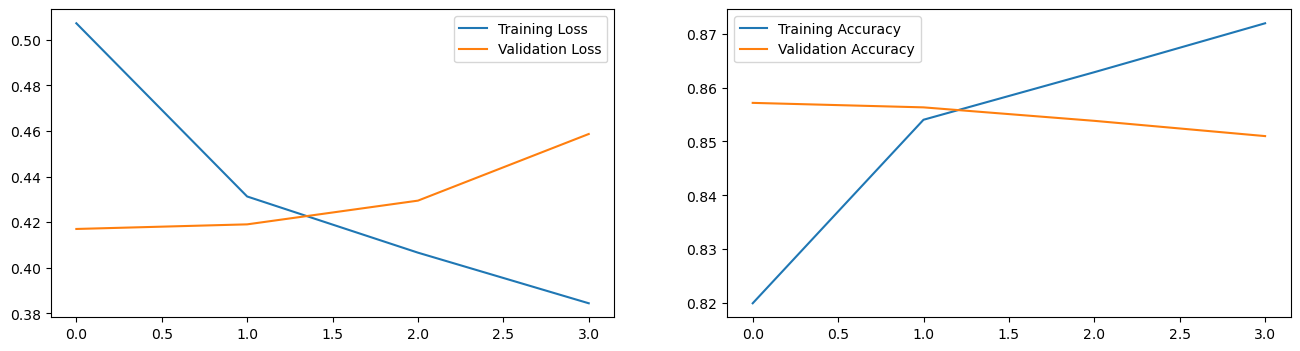

In [154]:
plot_history(history15)

Results

In [164]:
table = {
    "Model": ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5",
              "Model 6", "Model 7", "Model 8", "Model 9", "Model 10",
              "Model 11", "Model 12", "Model 13", "Model 14", "Model 15"],
    "Train Accuracy": [history1.history['accuracy'][8],history2.history['accuracy'][6],history3.history['accuracy'][3],
                      history4.history['accuracy'][8],history5.history['accuracy'][6],history6.history['accuracy'][8],
                      history7.history['accuracy'][7],history8.history['accuracy'][9],history9.history['accuracy'][9],
                      history10.history['accuracy'][3],history11.history['accuracy'][9],history12.history['accuracy'][6],
                      history13.history['accuracy'][9],history14.history['accuracy'][9],history15.history['accuracy'][3]],
    "Train Loss": [history1.history['loss'][8],history2.history['loss'][6],history3.history['loss'][3],
                      history4.history['loss'][8],history5.history['loss'][6],history6.history['loss'][8],
                      history7.history['loss'][7],history8.history['loss'][9],history9.history['loss'][9],
                      history10.history['loss'][3],history11.history['loss'][9],history12.history['loss'][6],
                      history13.history['loss'][9],history14.history['loss'][9],history15.history['loss'][3]],
    "Validation Accuracy":[history1.history['val_accuracy'][8],history2.history['val_accuracy'][6],history3.history['val_accuracy'][3],
                      history4.history['val_accuracy'][8],history5.history['val_accuracy'][6],history6.history['val_accuracy'][8],
                      history7.history['val_accuracy'][7],history8.history['val_accuracy'][9],history9.history['val_accuracy'][9],
                      history10.history['val_accuracy'][3],history11.history['val_accuracy'][9],history12.history['val_accuracy'][6],
                      history13.history['val_accuracy'][9],history14.history['val_accuracy'][9],history15.history['val_accuracy'][3]],
    "Validation Loss": [history1.history['val_loss'][8],history2.history['val_loss'][6],history3.history['val_loss'][3],
                      history4.history['val_loss'][8],history5.history['val_loss'][6],history6.history['val_loss'][8],
                      history7.history['val_loss'][7],history8.history['val_loss'][9],history9.history['val_loss'][9],
                      history10.history['val_loss'][3],history11.history['val_loss'][9],history12.history['val_loss'][6],
                      history13.history['val_loss'][9],history14.history['val_loss'][9],history15.history['val_loss'][3]],
    "Test Accuracy": [test_acc1,test_acc2,test_acc3,test_acc4,test_acc5,
                     test_acc6,test_acc7,test_acc8,test_acc9,test_acc10,
                     test_acc11,test_acc12,test_acc13,test_acc14,test_acc15],
    "Test Loss": [test_loss1,test_loss2,test_loss3,test_loss4,test_loss5,
                 test_loss6,test_loss7,test_loss8,test_loss9,test_loss10,
                 test_loss11,test_loss12,test_loss13,test_loss14,test_loss15,],
    "Process Time (s)":[second_elapsed_1,second_elapsed_2,second_elapsed_3,second_elapsed_4,second_elapsed_5,
                   second_elapsed_6,second_elapsed_7,second_elapsed_8,second_elapsed_9,second_elapsed_10,
                   second_elapsed_11,second_elapsed_12,second_elapsed_13,second_elapsed_14,second_elapsed_15]
}


In [165]:
df = pd.DataFrame(table)

In [166]:
from IPython.display import HTML

# Convert DataFrame to HTML with smaller font size
html_table = df.to_html(index=False, classes='table table-striped table-bordered', col_space=100, justify='center')

# Apply CSS to the HTML table to set font size
html_table = html_table.replace('<th>', '<th style="font-size: 10px;">')
html_table = html_table.replace('<td>', '<td style="font-size: 10px;">')

# Display the HTML table
HTML(html_table)

Model,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss,Process Time (s)
Model 1,0.857737,0.430454,0.852333,0.434577,0.851842,0.432646,2237
Model 2,0.857798,0.427172,0.851167,0.423470,0.852237,0.422857,1282
Model 3,0.251939,1.386994,0.251500,1.386619,0.250000,1.386617,594
Model 4,0.874877,0.364526,0.864500,0.378490,0.863158,0.393369,4639
Model 5,0.868667,0.379654,0.847667,0.448974,0.852763,0.424122,1297
Model 6,0.857526,0.411540,0.853167,0.422908,0.856184,0.424922,3568
Model 7,0.848254,0.465228,0.845667,0.460700,0.842632,0.456575,1771
Model 8,0.878763,0.351444,0.867500,0.384100,0.862105,0.393555,3472
Model 9,0.891491,0.310018,0.871500,0.391927,0.863553,0.384691,10967
Model 10,0.251491,1.386557,0.251500,1.386581,0.250000,1.386553,1014
